# Generate DEA Hotspots animations <img align="right" src="../Supplementary_data/dea_logo.jpg">

* **Compatability:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ls8_nbart_geomedian_annual](https://explorer.sandbox.dea.ga.gov.au/ls8_nbart_geomedian_annual)


## Description
This notebook loads DEA Hotspots data for a given time and location, and animates the data over a 2018 Geomedian underlay with fading colours that represent the age of the hotspot.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages

In [1]:
import os
import datacube
import pandas as pd
import geopandas as gpd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

import sys
sys.path.append('../Scripts')
from dea_spatialtools import xr_rasterize

# # Create custom cmap with dark grey at end 
fires_cmap = get_cmap('YlOrRd')
# fires_cmap.set_over('#111211')

dc = datacube.Datacube(app="DEA_hotspots")

# boundary = gpd.read_file('https://data.gov.au/geoserver/nsw-state-boundary/wfs?request=GetFeature&typeName=ckan_a1b278b1_59ef_4dea_8468_50eb09967f18&outputFormat=json')
boundary = gpd.read_file('https://raw.githubusercontent.com/rowanhogan/australian-states/master/states.geojson').simplify(tolerance=0.02)




## Parameters

Set parameters used to load and visualise DEA Hotspots data

In [34]:
# # Setup params
# name = 'actfire'  # name used for output files
# time_period = 15  # days from current date to include in animation (e.g. a month or week of data)
# to_date = (dt.datetime.today() + dt.timedelta(days=1)).strftime('%Y-%m-%d')
# from_date = (dt.datetime.today() - dt.timedelta(days=time_period)).strftime('%Y-%m-%d')
# y_max, x_min = -35.38, 148.68  # top left coordinates of bbox
# y_min, x_max = -36.02, 149.32  # bottom right coordinates of bbox
# min_confidence = 0  # minimum confidence value of hotspots to include in animation
# max_features = 900000  # maximum features to load from WFS
# avhrr=False

# Setup params
name = 'eastcoast'  # name used for output files
from_date = '2019-09-01'
to_date = '2020-02-15'
y_max, x_min = -27.00, 142.5  # top left coordinates of bbox
y_min, x_max = -39.2, 154.7  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
avhrr=False
modis=True
viirs=True

# Setup params
name = 'tiwi'  # name used for output files
from_date = '2020-08-25'
to_date = '2020-09-01'
y_max, x_min = -11.363076, 129.892554  # top left coordinates of bbox
y_min, x_max = -11.980380, 130.936255  # bottom right coordinates of bbox
min_confidence = 49  # minimum confidence value of hotspots to include in animation
max_features = 3000000  # maximum features to load from WFS
avhrr=False
modis=True
viirs=True

# Visualisation params
frame_freq = '0.5H'  # frequency used to generate animation frames (e.g. one frame every 3 hours). Smaller numbers create longer, smoother animations but take longer to render
hotspots_markersize = 2.5  # size to plot hotspots on map
hotspots_alpha = 0.15  # transperancy to plot hotspots on map
fade_hours = 24  # hours used to fade hotspots from yellow to black
geomedian_res = 0.005  # resolution in degrees to load geomedian underlay (smaller = slower rendering)

## Load and clean hotspots data

In [4]:
# Load WFS query data
avhrr_string = '(sensor=%27AVHRR%27%20AND%20(product=%27SRSS%27))%20OR%20' if avhrr else ''
modis_string = '(sensor=%27MODIS%27%20AND%20(product=%27MOD14%27))%20OR%20' if modis else ''
viirs_string = '(sensor=%27VIIRS%27%20AND%20(product=%27AFMOD%27%20OR%20product=%27EDR%27))' if viirs else ''
url = f"https://hotspots.dea.ga.gov.au/geoserver/public/wfs?service=WFS&version=1.1.0&request=GetFeature&typeName=public:hotspots&outputFormat=application/json&CQL_FILTER=({avhrr_string}{modis_string}{viirs_string})%20AND%20datetime%20%3E%20%27{from_date}%27%20AND%20datetime%20%3C%20%27{to_date}%27%20AND%20INTERSECTS(location,%20POLYGON(({y_min}%20{x_min},%20{y_min}%20{x_max},%20{y_max}%20{x_max},%20{y_max}%20{x_min},%20{y_min}%20{x_min})))&maxFeatures={max_features}&startIndex=0&sortBy=sensor%20A"
hotspots_gdf = gpd.read_file(url)
hotspots_gdf

,id,satellite,satellite_nssdc_id,satellite_operating_agency,sensor,orbit,start_dt,stop_dt,filename,process_dt,...,product,load_dt,latitude,longitude,temp_kelvin,power,confidence,datetime,australian_state,geometry
0,48591417,TERRA,1999-068A,NASA,MODIS,-1,2020-08-25T01:53:01,2020-08-25T02:09:49,Terra20200825T015301Z20200825T020949Zhotspots.txt,2020-08-25T02:30:41,...,MOD14,2020-08-25T02:30:44,-11.6190,130.6710,357.30,131.0,98,2020-08-25T01:58:47,None,POINT (130.67100 -11.61900)
1,48591418,TERRA,1999-068A,NASA,MODIS,-1,2020-08-25T01:53:01,2020-08-25T02:09:49,Terra20200825T015301Z20200825T020949Zhotspots.txt,2020-08-25T02:30:41,...,MOD14,2020-08-25T02:30:44,-11.6210,130.6850,329.10,32.5,79,2020-08-25T01:58:47,None,POINT (130.68500 -11.62100)
2,48591419,TERRA,1999-068A,NASA,MODIS,-1,2020-08-25T01:53:01,2020-08-25T02:09:49,Terra20200825T015301Z20200825T020949Zhotspots.txt,2020-08-25T02:30:41,...,MOD14,2020-08-25T02:30:44,-11.6300,130.6700,379.00,262.7,100,2020-08-25T01:58:47,None,POINT (130.67000 -11.63000)
3,48591420,TERRA,1999-068A,NASA,MODIS,-1,2020-08-25T01:53:01,2020-08-25T02:09:49,Terra20200825T015301Z20200825T020949Zhotspots.txt,2020-08-25T02:30:41,...,MOD14,2020-08-25T02:30:44,-11.6320,130.6840,346.20,81.2,92,2020-08-25T01:58:47,None,POINT (130.68400 -11.63200)
4,48591421,TERRA,1999-068A,NASA,MODIS,-1,2020-08-25T01:53:01,2020-08-25T02:09:49,Terra20200825T015301Z20200825T020949Zhotspots.txt,2020-08-25T02:30:41,...,MOD14,2020-08-25T02:30:44,-11.6410,130.6680,328.70,28.5,70,2020-08-25T01:58:47,None,POINT (130.66800 -11.64100)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,48630233,NOAA 20,2017-073A,NOAA,VIIRS,14370,2020-08-27T04:19:19,2020-08-27T04:34:56,J0120200827T041919Z20200827T043456Zhotspots.txt,2020-08-27T05:12:58,...,AFMOD,2020-08-27T05:13:33,-11.7642,130.5981,352.65,60.7,96,2020-08-27T04:32:06,None,POINT (130.59807 -11.76417)
399,48630234,NOAA 20,2017-073A,NOAA,VIIRS,14370,2020-08-27T04:19:19,2020-08-27T04:34:56,J0120200827T041919Z20200827T043456Zhotspots.txt,2020-08-27T05:12:58,...,AFMOD,2020-08-27T05:13:33,-11.7873,130.4269,318.63,9.9,57,2020-08-27T04:32:06,None,POINT (130.42693 -11.78726)
400,48630235,NOAA 20,2017-073A,NOAA,VIIRS,14370,2020-08-27T04:19:19,2020-08-27T04:34:56,J0120200827T041919Z20200827T043456Zhotspots.txt,2020-08-27T05:12:58,...,AFMOD,2020-08-27T05:13:33,-11.7377,130.7369,324.23,11.6,60,2020-08-27T04:32:06,None,POINT (130.73688 -11.73769)
401,48630236,NOAA 20,2017-073A,NOAA,VIIRS,14370,2020-08-27T04:19:19,2020-08-27T04:34:56,J0120200827T041919Z20200827T043456Zhotspots.txt,2020-08-27T05:12:58,...,AFMOD,2020-08-27T05:13:33,-11.7389,130.7276,336.79,26.9,87,2020-08-27T04:32:06,None,POINT (130.72765 -11.73894)


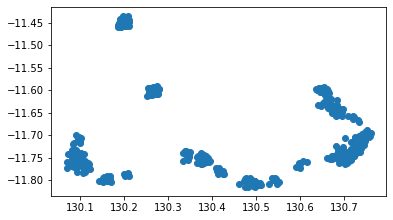

In [5]:
hotspots_gdf.plot()

In [15]:
# Filter by confidence
# hotspots_gdf = hotspots_gdf.loc[hotspots_gdf.confidence >= min_confidence]

# # Fix datetime
# hotspots_gdf['datetime'] = pd.to_datetime(hotspots_gdf['start_dt'])

# # # Extract required columns
# hotspots_gdf = hotspots_gdf.loc[:, [
#     'datetime', 'latitude', 'longitude', 'temp_kelvin', 'confidence', 'geometry'
# ]]
# hotspots_gdf.sort_values('datetime', ascending=True, inplace=True)
# hotspots_gdf.plot(column='datetime', cmap=fires_cmap, alpha=hotspots_alpha)

## Load 2018 geomedian underlay

In [22]:
# Create a query object
query = {
    "time": '2018',
    "x": (x_min, x_max),
    "y": (y_max, y_min),
    "measurements": ["red", "green", "blue"],
    "output_crs": "EPSG:4326",
    "resolution": (-geomedian_res, geomedian_res),
}

ds = dc.load(product="ls8_nbart_geomedian_annual", **query)

# boundary_xr = xr_rasterize(gdf=boundary, 
#              da=ds.red, 
#              x_dim='longitude', 
#              y_dim='latitude',
#              all_touched=True)

# ds = ds.where(boundary_xr, other=0)


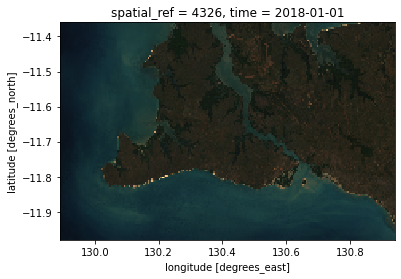

In [23]:
ds[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(vmax=4000)
# hotspots_gdf.plot(ax=plt.gca(), column='datetime', cmap=fires_cmap)

## Generate animation frames

In [33]:
to_date

'2020-09-00'

posx and posy should be finite values
posx and posy should be finite values


2020-08-25 00:00:00
2020-08-25 00:30:00
2020-08-25 01:00:00


posx and posy should be finite values
posx and posy should be finite values


2020-08-25 01:30:00
2020-08-25 02:00:00
2020-08-25 02:30:00
2020-08-25 03:00:00
2020-08-25 03:30:00
2020-08-25 04:00:00
2020-08-25 04:30:00
2020-08-25 05:00:00
2020-08-25 05:30:00
2020-08-25 06:00:00
2020-08-25 06:30:00
2020-08-25 07:00:00
2020-08-25 07:30:00
2020-08-25 08:00:00
2020-08-25 08:30:00
2020-08-25 09:00:00
2020-08-25 09:30:00
2020-08-25 10:00:00
2020-08-25 10:30:00
2020-08-25 11:00:00
2020-08-25 11:30:00
2020-08-25 12:00:00
2020-08-25 12:30:00
2020-08-25 13:00:00
2020-08-25 13:30:00
2020-08-25 14:00:00
2020-08-25 14:30:00
2020-08-25 15:00:00
2020-08-25 15:30:00
2020-08-25 16:00:00
2020-08-25 16:30:00
2020-08-25 17:00:00
2020-08-25 17:30:00
2020-08-25 18:00:00
2020-08-25 18:30:00
2020-08-25 19:00:00
2020-08-25 19:30:00
2020-08-25 20:00:00
2020-08-25 20:30:00
2020-08-25 21:00:00
2020-08-25 21:30:00
2020-08-25 22:00:00
2020-08-25 22:30:00
2020-08-25 23:00:00
2020-08-25 23:30:00
2020-08-26 00:00:00
2020-08-26 00:30:00
2020-08-26 01:00:00
2020-08-26 01:30:00
2020-08-26 02:00:00


KeyboardInterrupt: 

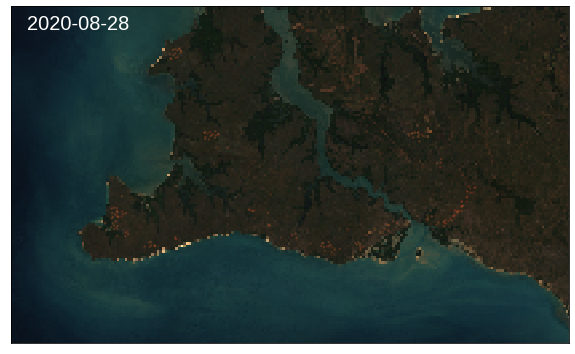

In [41]:
ds_ani = ds.copy(deep=True)

# If output folder doesn't exist, create it
output_dir = f'frames_{name}'
os.makedirs(output_dir, exist_ok=True)

# # Get date/times to iterate through (1 per frame)
# comp_dates = pd.date_range(hotspots_gdf.datetime.min(), 
#                            (dt.datetime.today() + dt.timedelta(days=0.7)), 
#                            freq=frame_freq)

# Get date/times to iterate through (1 per frame)
comp_dates = pd.date_range(from_date, 
                           to_date, 
                           freq=frame_freq)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, comp_date in enumerate(comp_dates):
    
    print(comp_date)

    # Extract only hotspots occuring prior to frame date/time
    hotspots_prev = hotspots_gdf.loc[
        hotspots_gdf['datetime'] < comp_date].copy()
    
    # Calculate hours between frame date and hotspot and sort
    hotspots_prev['hours_before'] = ((
        (comp_date - hotspots_prev['datetime'])).astype('timedelta64[m]') / 60)
    hotspots_prev.sort_values('hours_before', inplace=True, ascending=False)
    
    # Filter to most recent hours
    hotspots_prev = hotspots_prev[hotspots_prev.hours_before < fade_hours]

#     # Plot Geomedian as underlay
#     try:
#         burnt_pixels = xr_rasterize(gdf=hotspots_prev, 
#                                         da=ds.red, 
#                                         x_dim='longitude', 
#                                         y_dim='latitude',
#                                         all_touched=True)
#         ds_ani = ds_ani * (1 - burnt_pixels * 0.05)
#     except:
#         pass
    
    ds_ani[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(ax=ax, 
                                                                     vmax=4000)
    
    # Plot hotspots
    hotspots_prev.plot(ax=ax,
                       column='hours_before',
                       cmap=fires_cmap,
                       markersize=hotspots_markersize,
                       alpha=hotspots_alpha,
                       vmin=0,
                       vmax=fade_hours,
                      )
    
#     boundary.plot(linestyle=':', edgecolor='white', facecolor='none', ax=plt.gca())
    
#     labels = {'Sydney': (151.2093, -33.8688), 
#               'Canberra': (149.1300, -35.2809), 
#               'Melbourne': (144.9631, -37.8136)}

#     for label, (x, y) in labels.items():
#         plt.annotate(s=label,
#                          xy=(x + 0.25, y), 
#                          c='white',
#                          fontname='Liberation Sans',
#                          fontsize=10), 
    
    # Customise plot and add title
    ax.set_facecolor('black')
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('');
    ax.text(0.03, 0.95,
            f"{comp_date.tz_localize(tz='UTC').tz_convert('Australia/Sydney'):%Y-%m-%d}",
            ha='left', 
            va='center', 
            transform=ax.transAxes,
           fontdict={'fontsize': 20, 
                     'color': 'white', 
                     'fontname':'Liberation Sans'})
    
    # Export frame to file
    fig.savefig(f'{output_dir}/hotspots_{i}.png', 
#                 bbox_inches='tight',
#                 dpi=100,
#                 pad_inches=0
               )
    plt.cla()


## Combine into MP4 animation using FFMPEG

In [9]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -c:v libx264 -vf crop=in_w-15:in_h-15 -pix_fmt yuv420p $output_dir/hotspots_animation.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

In [ ]:
!ffmpeg -y -r 24 -i $output_dir/hotspots_%d.png -vf crop=in_w-15:in_h-15,minterpolate=fps=7 $output_dir/hotspots_animation.gif

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** January 2020

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)